In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from datascope.importance import SklearnModelAccuracy
from datascope.importance.shapley import ShapleyImportance, ImportanceMethod
from sklearn.pipeline import Pipeline

SEED = 78910
np.random.seed(SEED)

In [2]:
df = pd.read_csv('synthetic_letters_text_only.csv')
df

,letter,label
0,"To Whom It May Concern,\n\nI regret to write t...",negative
1,"To Whom It May Concern,\n\nI regret to inform ...",negative
2,"To Whom It May Concern,\n\nI am pleased to rec...",positive
3,"To whom it may concern,\n\nI am writing to rec...",neutral
4,"To Whom It May Concern,\n\nI regret to inform ...",negative
...,...,...
195,"To whom it may concern,\n\nI regret to inform ...",negative
196,"To Whom It May Concern,\n\nI regret to inform ...",negative
197,"Dear [Recipient's Name],\n\nI regret to inform...",negative
198,"To whom it may concern,\n\nI am pleased to rec...",positive


In [3]:
train, rest = train_test_split(df, test_size=0.5, random_state=SEED)
valid, test = train_test_split(rest, test_size=0.5, random_state=SEED)

encoder = SentenceTransformer("all-MiniLM-L6-v2")
X_train = encoder.encode(list(train.letter))
X_valid = encoder.encode(list(valid.letter))
X_test = encoder.encode(list(test.letter))


label_encoder = LabelEncoder().fit(train.label)
y_train = label_encoder.transform(train.label)
y_valid = label_encoder.transform(valid.label)
y_test = label_encoder.transform(test.label)

utility = SklearnModelAccuracy(SGDClassifier(loss='log_loss', random_state=SEED))

In [4]:
utility(X_train, y_train, X_test, y_test).score

0.84

In [5]:
def inject_label_errors(original_labels, fraction, label_encoder):
    labels_with_errors = copy.deepcopy(original_labels)
    count = int(len(labels_with_errors) * fraction)
    indices_for_errors = np.random.choice(range(len(labels_with_errors)), count, replace=True)
    
    for idx in indices_for_errors:
        true_label = labels_with_errors[idx]
        other_labels = [label for label in range(len(label_encoder.classes_)) if label != true_label]
        labels_with_errors[idx] = np.random.choice(other_labels)
    
    return labels_with_errors    

In [6]:
y_train_mislabeled = inject_label_errors(y_train, fraction=0.5, label_encoder=label_encoder)

utility(X_train, y_train_mislabeled, X_test, y_test).score

0.56

In [7]:
from datascope.importance import Importance
from typing import Optional, Iterable, Union
from pandas import DataFrame, Series
from numpy.typing import NDArray
from datascope.utility import Provenance

# TODO this should be part of the datascope package
class LooImportance(Importance):
    
    def __init__(self, utility):
        self.utility = utility
        super().__init__()

    def _fit(
        self,
        X: NDArray,
        y: Union[NDArray, Series],
        metadata: Optional[Union[NDArray, DataFrame]],
        provenance: Provenance,
    ) -> "Importance":
        self.X_train_ = X
        self.y_train_ = y
        self.provenance = provenance
        return self

    def _score(
        self,
        X_valid: NDArray,
        y_valid: Optional[Union[NDArray, Series]] = None,
        metadata: Optional[Union[NDArray, DataFrame]] = None,
        **kwargs
    ) -> Iterable[float]:

        print(self.provenance.num_units)
        
        complete_utility = self.utility(self.X_train_, y_train, X_valid, y_valid).score
        
        #TODO this should use the provenance instead to correctly remove samples                    
        loos = []
        assignment = np.ones(self.provenance.num_units)
        
        previous_index = 0
        for index in range(self.provenance.num_units):
            assignment[previous_index] = 1
            assignment[index] = 0
            previous_index = index    
            outputs = self.provenance.query(assignment)
            # Find indices of zero elements
            indices_to_delete = np.nonzero(outputs==0)[0]            
            X_train_loo = np.delete(self.X_train_, indices_to_delete, 0)
            y_train_loo = np.delete(y_train, indices_to_delete, 0)                    
            loo = complete_utility - self.utility(X_train_loo, y_train_loo, X_valid, y_valid).score
            loos.append(loo)
        return loos

loo_importance = LooImportance(utility=utility)

loo_values = loo_importance.fit(X_train, y_train_mislabeled).score(X_valid, y_valid)

100


In [8]:
dsv_importance = ShapleyImportance(method=ImportanceMethod.NEIGHBOR, utility=utility)

dsvs = dsv_importance.fit(X_train, y_train_mislabeled).score(X_valid, y_valid)

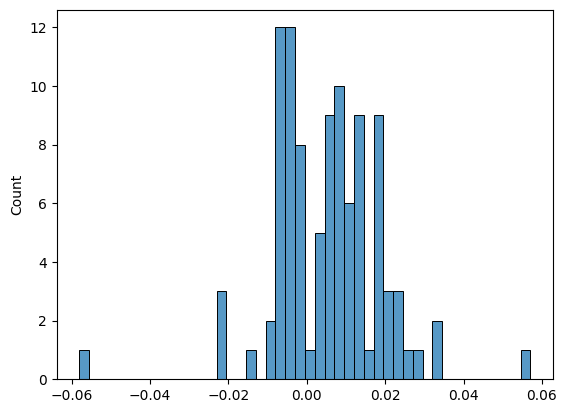

In [9]:
sns.histplot(data=dsvs, binwidth=0.0025)
plt.show()

In [10]:
for index in np.argsort(dsvs)[:5]:
    print(f'''
Data Shapley value: {dsvs[index]}
Given label: {label_encoder.inverse_transform([y_train_mislabeled[index]])[0]}
True label: {label_encoder.inverse_transform([y_train[index]])[0]}

{train.iloc[index].letter}

{'-'*80}
''')


Data Shapley value: -0.057994969635183226
Given label: positive
True label: negative

To Whom It May Concern,

I am writing to express my reservations regarding [person]'s performance during their time in the health sector. Despite their enthusiasm, [person] often struggled with basic patient care tasks, including effective communication with patients and maintaining accurate medical records. Additionally, their inability to follow established health protocols resulted in delays in treatment and created unnecessary confusion among staff. While [person] has shown a willingness to learn, their retention of essential information has been inadequate. Therefore, I cannot recommend [person] for a position within any health-related field without significant reservations.

Sincerely,  
[Your Name]  
[Your Position]  

--------------------------------------------------------------------------------


Data Shapley value: -0.02283234763861401
Given label: neutral
True label: negative

To Whom It

In [11]:
def evaluate_repairs(indices_to_repair, X_train, y_train_mislabeled, y_train, X_test, y_test, utility):
    y_train_with_repairs = copy.deepcopy(y_train_mislabeled)
    scores = []
    
    for index in indices_to_repair:
        y_train_with_repairs[index] = y_train[index]
        score = utility(X_train, y_train_with_repairs, X_test, y_test).score
        scores.append(score)

    return scores

In [12]:
num_negative_dsvs = np.sum(dsvs < 0)
indices_to_repair_dsv = np.argsort(dsvs)[:num_negative_dsvs]

repair_scores_dsv = evaluate_repairs(indices_to_repair_dsv, X_train, y_train_mislabeled, y_train, X_test, y_test, utility)

In [13]:
random_indices = np.random.choice(range(len(X_train)), num_negative_dsvs, replace=False)

repair_scores_random = evaluate_repairs(random_indices, X_train, y_train_mislabeled, y_train, X_test, y_test, utility)

In [14]:
loo_indices = np.argsort(loo_values)[:num_negative_dsvs]
loo_indices = [idx for idx in loo_indices if loo_values[idx] < 0.0]

repair_scores_loo = evaluate_repairs(loo_indices, X_train, y_train_mislabeled, y_train, X_test, y_test, utility)

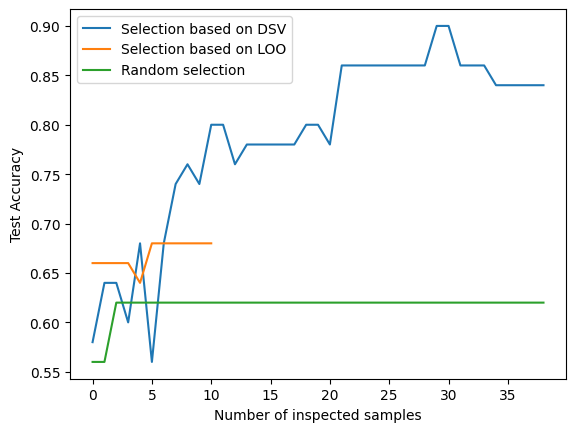

In [15]:
from scipy.ndimage import gaussian_filter1d

ax = sns.lineplot(repair_scores_dsv, label="Selection based on DSV")
ax = sns.lineplot(repair_scores_loo, label="Selection based on LOO")
ax = sns.lineplot(repair_scores_random, label="Random selection")


ax.set_xlabel("Number of inspected samples")
ax.set_ylabel("Test Accuracy")
ax.legend()

plt.show()